*Copyright (C) 2021-2022 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

# Solving Quadratic Programs with Lava and Loihi

Quadratic Programs can be solved using a first-order update scheme called PIPGeq [1]  (Proportional Integral Projected Gradient), an algorithm to solve equality constrained Quadratic Programs with quadratic convergence for solution and cubic convergence for constraint satisfaction for strongly convex cases. It has been designed keeping edge-level MPC in mind. <br>
The scope for parallelization in these kinds of problems along with the sparsity in connectivity, make it an ideal class of problems that can be solved on Loihi. In this tutorial We shall explore how this solver is used in the Lava framework in the optimization library with a floating-point CPU backend and also how the solver currently runs on Loihi 2, thereby demonstrating the first known QP solver on neuromorphic hardware.
<br> [1] (https://ieeexplore.ieee.org/document/9295329)

### Recommended Tutorials before starting

- [Installing Lava](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial01_installing_lava.ipynb)
- [Processes](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial02_processes.ipynb "Tutorial on Processes")
- [ProcessModel](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial03_process_models.ipynb "Tutorial on ProcessModels")
- [Execution](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial04_execution.ipynb "Tutorial on Executing Processes")
- [Quadratic Programming in Lava](https://github.com/lava-nc/lava-optimization/blob/main/tutorials/tutorial_01_solving_lasso.ipynb)

### PIPG to solve QPs on Loihi

Consider a QP of the following form:
$$ \text{argmin} \frac{1}{2}x^TQx + p^Tx $$
$$ \text{s.t.  } Ax = k,$$
$$ l \le x \le u $$
where $ x \in \mathbb{R}^n$, $ Q \in \mathbb{S}_{+}^{n \times n}$, $ p \in \mathbb{R}^n$ , $ A \in \mathbb{R}^{m \times n} $ and $ k \in \mathbb{R}^m$ where $m$ and $n$ are integers. $l$ and $u$ are lower and upper bounds on the variable x. This can be solved with the following first-order iterative update scheme,

$$ v_j = w_j + \beta_j \cdot (Ax_j - k) $$
$$ x_{j+1} = \pi_{X}(x_j - \alpha_j \cdot (Qx_j + p + A^Tv_j)) $$
$$ w_{j+1} = w_j + \beta_j \cdot (Ax_{j+1} - k) $$

The decay/growth parameters are given by:
$$ \alpha_k = \frac{2}{(k+1)\cdot\mu + 2\lambda} \text{ and } \beta_k = \frac{(k+1)\cdot\mu}{2\sigma}$$
where $ \mu I \le Q \le \lambda I$ and $ A^TA \le \sigma I$
The above equations can be reduced to the following process models in Lava 

we assume no bounds on the variable $x$ and therefore in the above equations, $\pi_X(x) = \text{min}(\text{max}(x, - \infty), \infty) = x$

#### Load Data

We use data from 1 run of the ANYmal Model Predictive Control problem for different horizon lengths, $N$ (5 and  later 100). Accordingly we get matrices that form that together constitute the QP shown above. The data for the QP is obtained from the Optimal control for Switched Systems [2] (OCS2) toolbox 
<br> [2] OCS2: An open source library for optimal control of switched systems,” [Online]. Available: https://github.com/leggedrobotics/ocs2

In [1]:
import numpy as np
from scipy.spatial import distance
from scipy import sparse
import matplotlib.pyplot as plt
import time

In [2]:
a = np.load('data/ex_qp_small.npz')
Q, A, p, k = [a[i] for i in a] 

In [3]:
Q.shape, A.shape, p.shape, k.shape

((264, 264), (144, 264), (264, 1), (144, 1))

### Preconditioning the Problem 

We use the ruiz equilibriation class of preconditioners which are a cheap class of diagonal preconditioners that can speed-up the convergence of first-order methods to solve QPs. The preconditioner is intended to run on the host CPU. The preconditioned problem is then set up on neuromorphic hardware. The preconditioner we use is defined below.

In [4]:
def ruiz_equilibriation(matrix, iterations):
    m_bar = matrix 
    left_preconditioner = sparse.csc_matrix(np.eye(matrix.shape[0]))
    right_preconditioner = sparse.csc_matrix(np.eye(matrix.shape[1]))
    row_del, col_del = 0, 0
    for i in range(iterations):
        D_l_inv = sparse.csc_matrix(np.diag(1/np.sqrt(np.linalg.norm(m_bar, ord=2, axis=1))))
        if(m_bar.shape[0] != m_bar.shape[1]):
            D_r_inv = sparse.csc_matrix(np.diag(1/np.sqrt(np.linalg.norm(m_bar, ord=2, axis=0))))
        else:
            D_r_inv = D_l_inv
            
        m_bar = D_l_inv@m_bar@D_r_inv
        left_preconditioner = left_preconditioner@D_l_inv
        #right_preconditioner = right_preconditioner@D_r_inv
        row_del = np.max(np.abs(1-np.linalg.norm(m_bar, ord=2, axis=1))) 
    return left_preconditioner, right_preconditioner, m_bar

In [5]:
pre_mat_Q, _, _ = ruiz_equilibriation(Q, 5)
Q_pre = pre_mat_Q@Q@pre_mat_Q
p_pre = pre_mat_Q@p

pre_mat_A, _, _ = ruiz_equilibriation(A, 5)
A_pre = pre_mat_A@A@pre_mat_Q
k_pre = pre_mat_A@k

### A Loihi compatible approach for solver decay/growth

The bounds on the solver decay/growth rates are decided based on the eigenvalues of the matrices of the QP $Q$ and $A^TA$ ($Q_{pre}$ and $A_{pre}$) matrices as explained in the introduction. We use values of initial value of constant tha lie within these bounds. We get the initial values of $\alpha$ and $\beta$ using these constants and the equations explained in the introduction

In [6]:
mu, sigma, lamda =  0.11, 8.14, 1.6
def alpha_pipg(k):
    return 2/((k+1)*mu + 2*lamda)

def beta_pipg(k):
    return (k+1)*mu/(2*sigma)

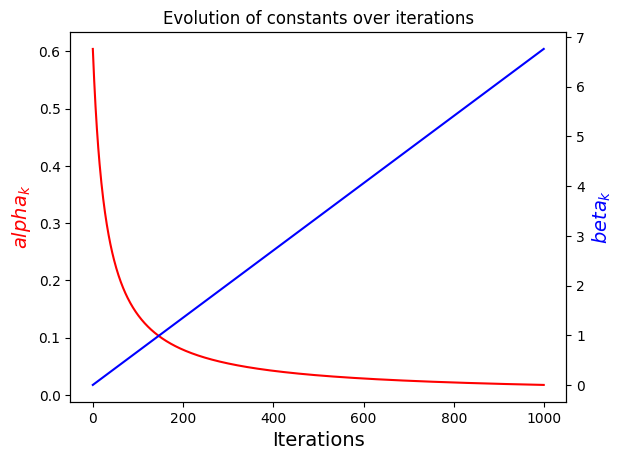

In [7]:
alpha_l, beta_l  = [], []
for i in range(1000):
    alpha_l.append(alpha_pipg(i))
    beta_l.append(beta_pipg(i))
fig,ax = plt.subplots()
plt.title("Evolution of constants over iterations")
ax.plot(alpha_l, color="red")
ax.set_xlabel("Iterations",fontsize=14)
ax.set_ylabel("$alpha_k$",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(beta_l,color="blue")
ax2.set_ylabel("$beta_k$",color="blue",fontsize=14)
plt.show()

In Loihi, the evolution of alpha and beta cannot be done as shown in the equation and has to be controlled by right (decrease) and left shifts (increase). Keeping this in mind we inspect the above graph and choose the following decay indices.

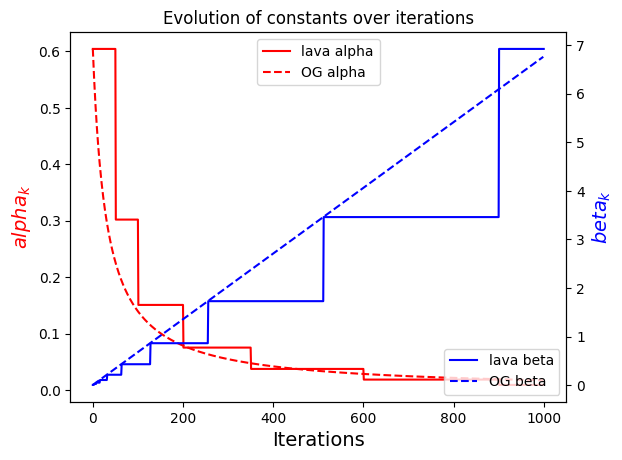

In [8]:
alpha_decay_indices = [50, 100, 200, 350, 600, 900]
beta_growth_indices = [1, 3, 7, 15, 31, 63, 127, 255, 511, 900]
alpha_lava_l , beta_lava_l = [], []
alpha_lava, beta_lava = alpha_pipg(0), beta_pipg(0)
alpha_lava_l.append(alpha_lava)
beta_lava_l.append(beta_lava)
for i in range(1000):
    if (i in alpha_decay_indices):
        alpha_lava/=2
    if (i in beta_growth_indices):
        beta_lava*=2  
    alpha_lava_l.append(alpha_lava)
    beta_lava_l.append(beta_lava)
fig,ax = plt.subplots(dpi=100)
plt.title("Evolution of constants over iterations")
ax.plot(alpha_lava_l, color="red", label='lava alpha')
ax.plot(alpha_l,'--', color="red", label='OG alpha')
ax.set_xlabel("Iterations",fontsize=14)
ax.set_ylabel("$ alpha_k $",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(beta_lava_l,color="blue", label='lava beta')
ax2.plot(beta_l,'--', color="blue", label='OG beta')
ax2.set_ylabel("$ beta_k $",color="blue",fontsize=14)
ax.legend(loc='upper center')
ax2.legend(loc='lower right')
plt.show()

### PIPG solver in Lava - Eventified floating point Operation

We now run an eventified version of the QP solver with full floating point precision. The underlying algorithm is PIPGeq. The processes with their behavior models are illustrated below

In [9]:
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.lib.optimization.solvers.qp.models import (
    ProjectedGradientNeuronsPIPGeq,
    ProportionalIntegralNeuronsPIPGeq,
    SigmaNeurons,
    DeltaNeurons
)
from lava.proc.dense.process import Dense

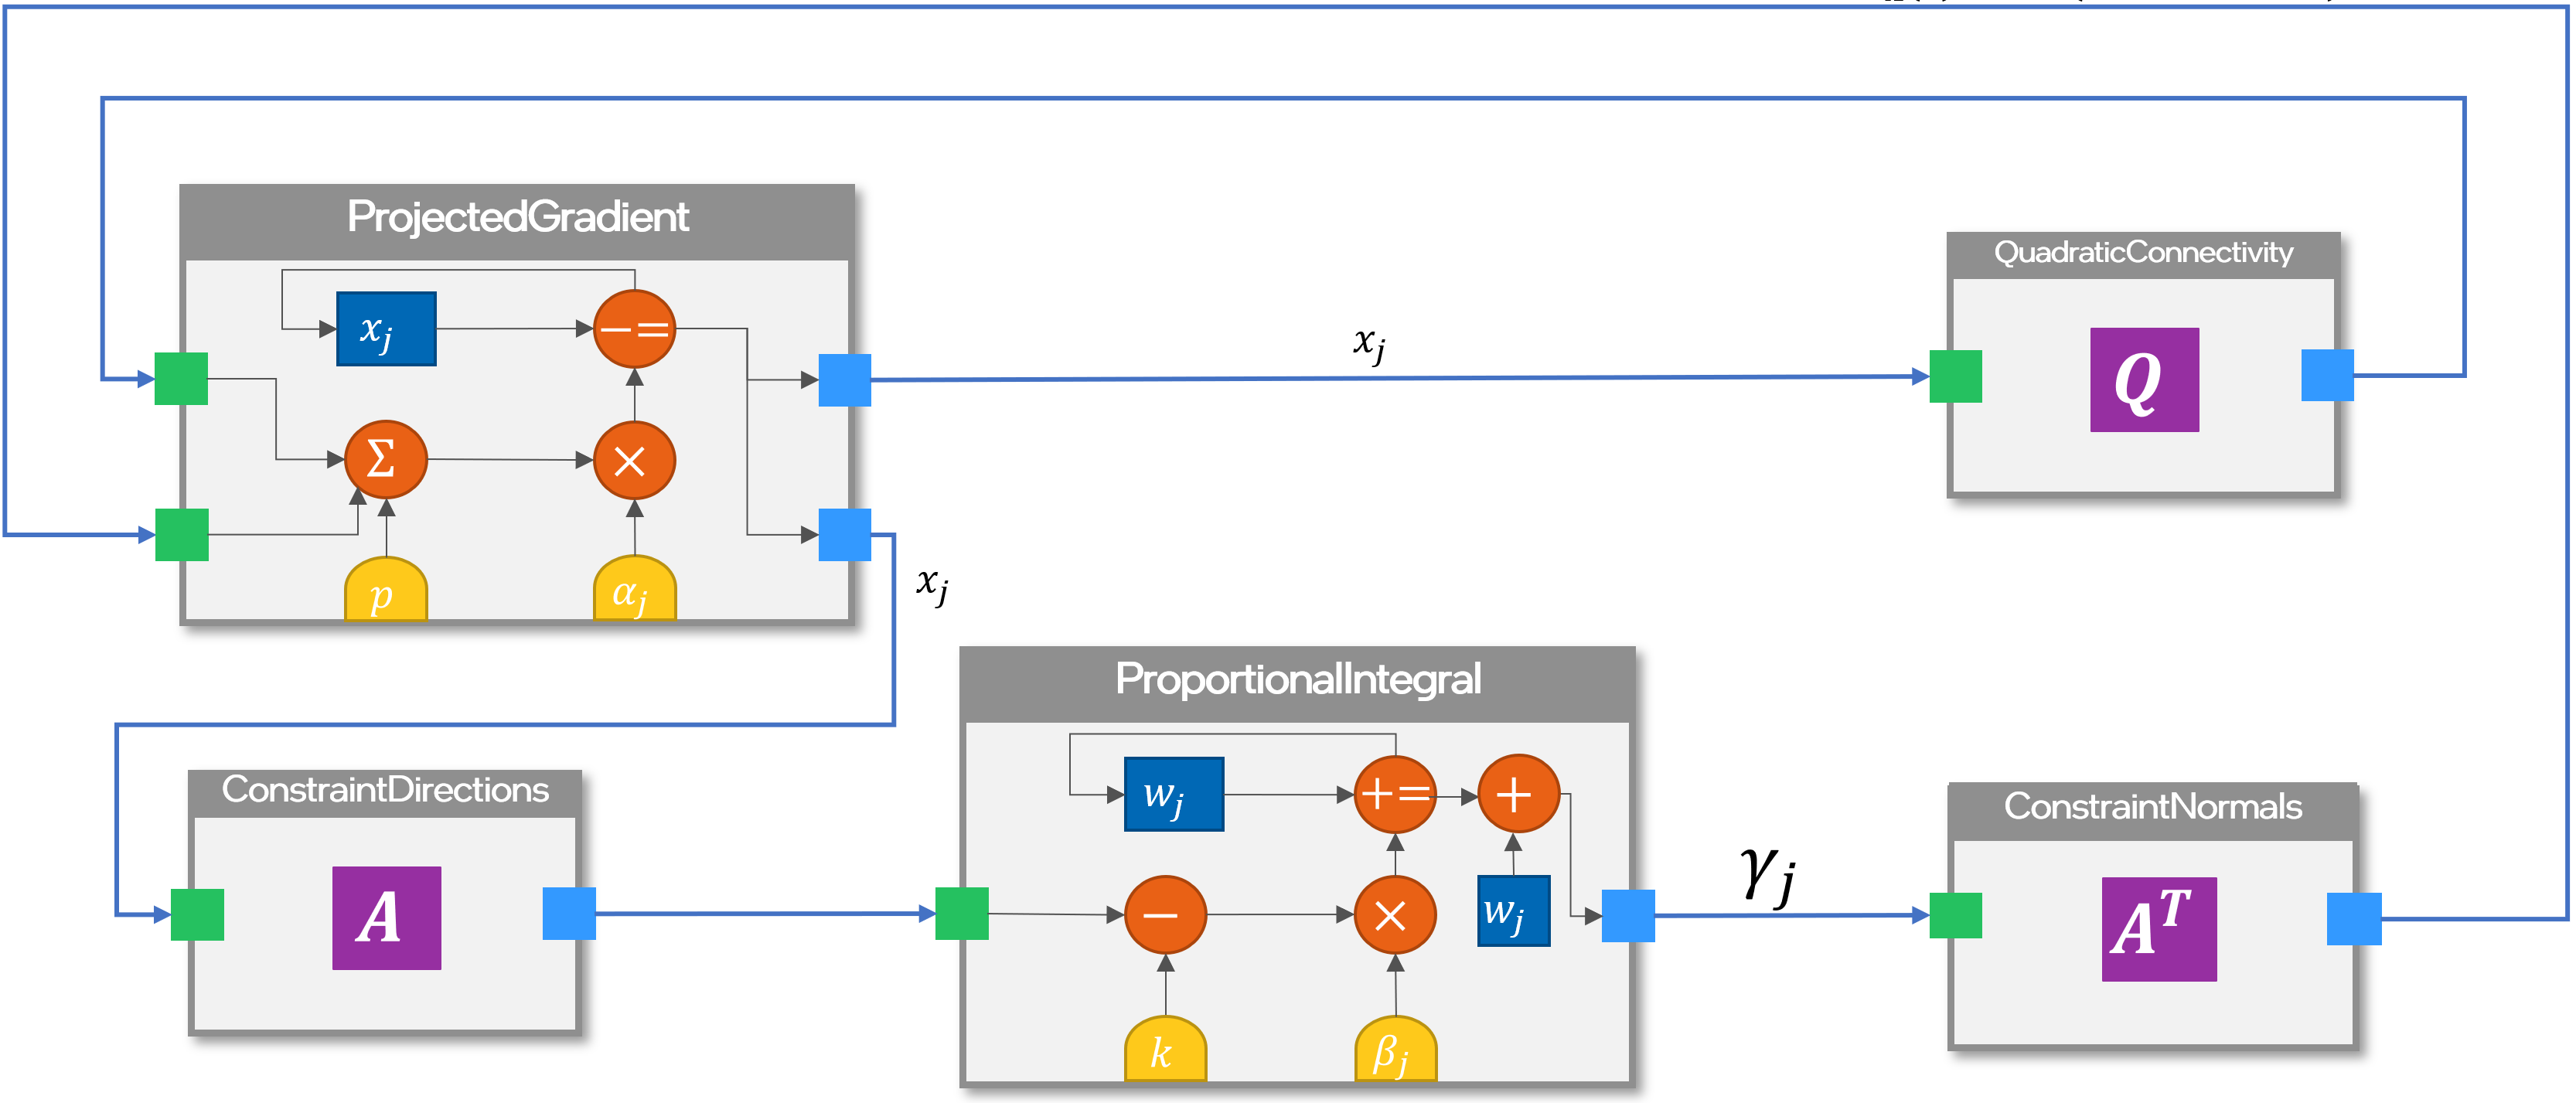

Note that the matrices are represented as Connection processes in the process diagram. In Lava these connection process are implemented by using the in-built `Dense` or `Sparse` processes and their corresponding models. The Lava solver uses 2 timesteps to carry out 1 timestep in the original PIPGeq algorithm. This is becaue of buffering of spikes in the connection process. The `ProjectedGradient` neurons operate in the even time-step and the `ProportionalIntegral` neurons operate in the odd-timestep. The decay and growth indices are therefore scaled accordingly to comply with this new notion of 1 PIPG time-step. 

In [10]:
alpha_decay_indices = (
    np.array([50, 100, 200, 350, 550, 800, 1100, 1450, 1850, 2300])*2
)
beta_growth_indices = (
    np.array([1, 3, 7, 15, 31, 63, 127, 255, 511, 1023, 2047, 4095,])*2 + 1
)

We now initialize the process that have to used as part of the solver and wire them up as per the topology shown in the figure before. The processes are availabe in the `lava-optimization` library. We select floating-point backends by specifying the particular models in `exception_proc_model_map`.

In [46]:
from lava.lib.optimization.solvers.qp.models import (
    PyPIneurPIPGeqModel,
    PyProjGradPIPGeqModel,
)
from lava.proc.dense.models import PyDenseModelFloat
from lava.magma.core.run_configs import Loihi2HwCfg

# Lava process Initalization for PIPGeq
# Neuron Processes
ProjGrad = ProjectedGradientNeuronsPIPGeq(shape=(p_pre.shape[0],), 
                                           qp_neurons_init=np.zeros(
                                            (p_pre.shape[0],)
                                            ),
                                           grad_bias=p_pre.reshape(
                                            p_pre.shape[0], 
                                            ),
                                           alpha=alpha_pipg(0),
                                           lr_decay_type = 'indices',
                                           alpha_decay_indices = alpha_decay_indices)

ProInt = ProportionalIntegralNeuronsPIPGeq(shape=(k_pre.shape[0],), 
                                           constraint_neurons_init=np.zeros(
                                            (k_pre.shape[0],)
                                            ),
                                           thresholds=k_pre.reshape(
                                            k_pre.shape[0],
                                            ),
                                           beta=beta_pipg(0),
                                           lr_growth_type = 'indices',
                                           beta_growth_indices = beta_growth_indices 
                                           )

# Connection Processes. Specify num_message_bits > 1 to use graded spikes
ConsDir = Dense(weights=A_pre, num_message_bits=64)
ConsNorm = Dense(weights=A_pre.T, num_message_bits=64)
QuadConn = Dense(weights=Q_pre, num_message_bits=64)

# Connecting Processes together
QuadConn.a_out.connect(ProjGrad.a_in_qc)
ConsNorm.a_out.connect(ProjGrad.a_in_cn)
ProjGrad.s_out_qc.connect(QuadConn.s_in)
ProjGrad.s_out_cd.connect(ConsDir.s_in)
ConsDir.a_out.connect(ProInt.a_in)
ProInt.s_out.connect(ConsNorm.s_in)

# Run solver dynamics QP
iterations = 1500*2
# Specify floating-point models of the processes 
exception_proc_model_map = { 
    ProportionalIntegralNeuronsPIPGeq: PyPIneurPIPGeqModel,
    ProjectedGradientNeuronsPIPGeq: PyProjGradPIPGeqModel,
    Dense:  PyDenseModelFloat
}
run_config = Loihi2HwCfg(exception_proc_model_map=exception_proc_model_map)
constraint_violation = []
cost = []
for i in range(iterations):
    ProjGrad.run(condition=RunSteps(num_steps=1), run_cfg=run_config)
    if i%2==0:
        x_pre = ProjGrad.qp_neuron_state.get()
        x_post = pre_mat_Q @x_pre
        cost.append(-(x_post.T@Q@x_post/2 + p.T@x_post))
        constraint_violation.append(np.linalg.norm(A@x_post))

# stop process execution
ProjGrad.stop()

# postconditioning to get actual solution
sol_k =  pre_mat_Q@x_pre
print("The constraint violation is {}".format(np.linalg.norm(A@sol_k-k)))

The constraint violation is 0.0660402689200399


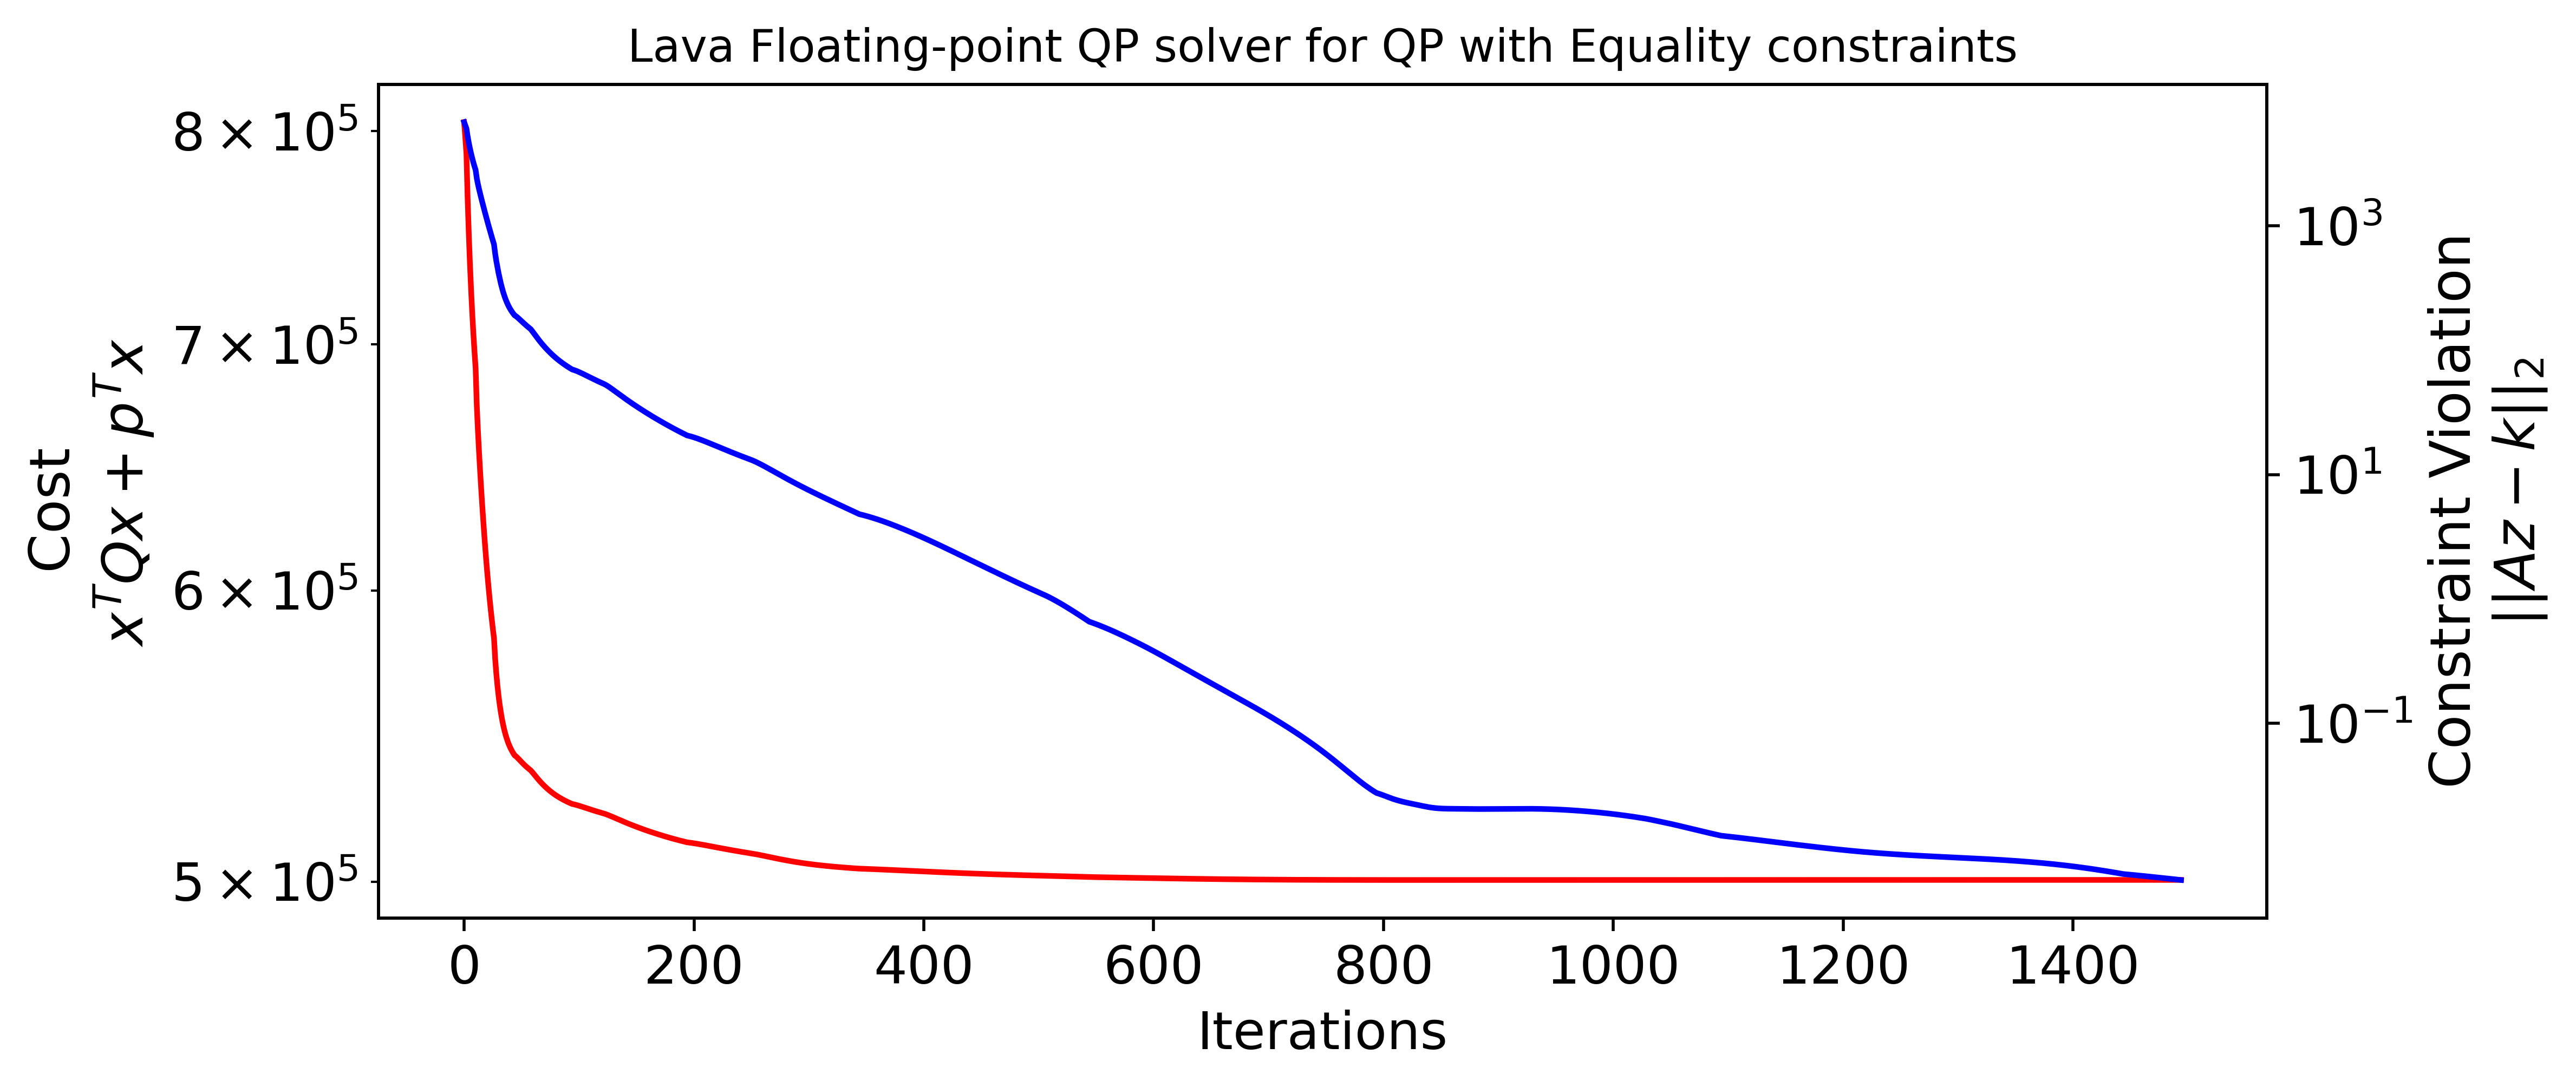

In [45]:
fig,ax = plt.subplots(figsize=(9, 4), dpi=500)
plt.rcParams.update({'font.size': 14})

plt.title("Lava Floating-point QP solver for QP with Equality constraints", fontsize=12)
ax.set_xlabel("Iterations")
ax.plot(cost[5:], color="red")
ax.set_ylabel("Cost \n $  x^T Q x + p^Tx $",fontsize=15)
ax.set_yscale('log')

ax2=ax.twinx()
ax2.plot(constraint_violation[5:],color="blue")
ax2.set_ylabel("Constraint Violation \n $ ||Az-k||_2 $",fontsize=15)
ax2.set_yscale('log')
plt.show()

We see from the plots above that the eventified Lava floating-point solver converges to solution fairly well while the cost also decreases. Thus the QP solver in Lava is functional.

## Quadratic Programming on Loihi 2

We now move to running the QP solver on Loihi 2 using Lava. We use the same process as shown in the CPU-based solver. The backend specification in the `run_config` chooses the model that must be used to run on Loihi 2. Note that this section of the tutorial can only be run by users part of the Intel Neuromorphic Research Community (INRC) since it requires access to hardware. 

We specify environmet variables that enable running the workload on the hardware. Note that depending on availabilty (checked using the command `sinfo`), user will have to change the `PARTITION` and `BOARD` parameters.

In [13]:
## Environment variables
%env SLURM=1
%env LOIHI_GEN=N3B3
%env PARTITION=kp
%env BOARD=ncl-og-06

env: SLURM=1
env: LOIHI_GEN=N3B3
env: PARTITION=kp
env: BOARD=ncl-og-06


#### Float2fixed Conversion

The QP has to be mapped to Loihi 2 in accordance with the data types it uses. Therefore the floating-point problem has to be converted to a fixed-point equivalent under the limitations of the architecture. In Loihi 2, spikes are represented as 24-bit integers. The weights are represented with 8 bits with 1 bit used for the sign if the wieghts are signed. Additionaly one can specify an exponent for a connection process. The exponent can be a number that can be represented with 6-bit including sign. Further the state variables in the QP solver use 24 bits for their representation. 
 

In [14]:
def convert_to_fp(mat, man_bits):
    """Function that returns the exponent, mantissa representation for
    floating point numbers that need to be represented on Loihi. A global exp
    is calculated for the matrices based on the max absolute value in the
    matrix. This is then used to calculate the manstissae in the matrix.

    Args:
        mat (np.float): The input floating point matrix that needs to be
        converted
        man_bits (int): number of bits that the mantissa uses for it's
        representation (Including sign)

    Returns:
        mat_fp_man (np.int): The matrix in
    """
    exp = np.ceil(np.log2(np.max(np.abs(mat)))) - man_bits + 1
    mat_fp_man = (mat // 2**exp).astype(int)
    return mat_fp_man.astype(int), exp.astype(int)

The `alpha_decay_indices` and `beta_growth_indices` explained in the CPU-backend section are computed on the fly in the QP solver during execution in the solver uC engine. As a result, this requires specification of addition parameters `growth_factor`, `growth_index`, `decay_factor`, `decay_index` and `decay_interval`. The behavior of these parameters is described in the documentation of the processes. 

In [15]:
# Generate growth schedule for beta
growth_factor = 2
growth_index = 3

# generate decay schedule for alpha
decay_factor = 0
decay_index = 100
decay_interval = 100

Q_pre_fp_man, Q_pre_fp_exp = convert_to_fp(Q_pre, 8)
A_pre_fp_man, A_pre_fp_exp = convert_to_fp(A_pre, 8)
p_pre_fp_man, p_pre_fp_exp = convert_to_fp(p_pre, 24)
k_pre_fp_man, k_pre_fp_exp = k_pre.astype(int), 0  # vector of zeros

# Initial learning-rate mantissae
beta_man = 7
alpha_man = 160

# Initial learning-rate exponent
alpha_exp = -8
beta_exp = -10

# Right shifting of the exponent is done in microcode to increase accuracy
# Use of two ports necessitates first left-shifting in the connection processes
# and then right-shifting in the neuron microcode
correction_exp = min(A_pre_fp_exp, Q_pre_fp_exp)

Q_exp_new, A_exp_new = (
    -correction_exp + Q_pre_fp_exp,
    -correction_exp + A_pre_fp_exp,
)

### Lava processes for solving QP  

In [16]:
from lava.lib.optimization.solvers.qp.processes import (
    ProjectedGradientNeuronsPIPGeq,
    ProportionalIntegralNeuronsPIPGeq,
)

# Neurons for Gradient descent
ProjGrad = ProjectedGradientNeuronsPIPGeq(
            shape=(p_pre_fp_man.shape[0],),
            da_exp=correction_exp,
            grad_bias=p_pre_fp_man,
            grad_bias_exp=p_pre_fp_exp,
            alpha=alpha_man,
            alpha_exp=alpha_exp,
            lr_decay_type="indices",
            alpha_decay_params=(decay_index, decay_interval, decay_factor),
        )

# Neurons for Constraint Checking
ProInt = ProportionalIntegralNeuronsPIPGeq(
            shape=(k_pre_fp_man.shape[0],),
            da_exp=A_pre_fp_exp,
            thresholds=k_pre_fp_man,
            thresholds_exp=k_pre_fp_exp,
            beta=beta_man,
            beta_exp=beta_exp,
            lr_growth_type="indices",
            beta_growth_params=(growth_index, growth_factor),
        )
        
# Connection processes
from lava.proc.dense.process import Dense

dense_Q = Dense(
    weights=Q_pre_fp_man, weight_exp=Q_exp_new, num_message_bits=24
)
dense_A = Dense(
    weights=A_pre_fp_man,
    num_message_bits=24,
)
dense_A_T = Dense(
    weights=A_pre_fp_man.T, weight_exp=A_exp_new, num_message_bits=24
)

In [17]:
# Connection topology
dense_Q.a_out.connect(ProjGrad.a_in_qc)
dense_A_T.a_out.connect(ProjGrad.a_in_qc)
ProjGrad.s_out_qc.connect(dense_A.s_in)
ProjGrad.s_out_qc.connect(dense_Q.s_in)
dense_A.a_out.connect(ProInt.a_in)
ProInt.s_out.connect(dense_A_T.s_in)

#### Running the solver on Loihi 2

In [18]:
from lava.lib.optimization.solvers.qp.ncmodels import (
    NcL2ModelPG,
    NcL2ModelPI,
)
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2HwCfg

# Control this to increase/decrease solver iterations 
num_steps = 300*2

exception_proc_model_map = { 
    ProportionalIntegralNeuronsPIPGeq: NcL2ModelPI,
    ProjectedGradientNeuronsPIPGeq: NcL2ModelPG,
}
run_config = Loihi2HwCfg(exception_proc_model_map=exception_proc_model_map)

constraint_violation = []
cost = []
for i in range(num_steps):
    ProjGrad.run(condition=RunSteps(num_steps=1), run_cfg=run_config)
    if i%2==0:
        x_pre = ProjGrad.qp_neuron_state.get()
        x_post = pre_mat_Q @x_pre
        cost.append(-(x_post.T@Q@x_post/2 + p.T@x_post))
        constraint_violation.append(np.linalg.norm(A@x_post))
ProjGrad.stop()

Violation core_id=0 reg_name='SynMem' allocation=33864 self.cost_db.registers[reg_name]=12000
Violation core_id=1 reg_name='SynMem' allocation=12144 self.cost_db.registers[reg_name]=12000
Final max_ratio=3, Violation core_id=0 reg_name='SynMem' allocation=33864 self.cost_db.registers[reg_name]=12000
Final max_ratio=2, Violation core_id=1 reg_name='SynMem' allocation=12144 self.cost_db.registers[reg_name]=12000
Final max_ratio=3, Violation core_id=0 reg_name='SynMem' allocation=29376 self.cost_db.registers[reg_name]=12000
Final max_ratio=2, Violation core_id=2 reg_name='SynMem' allocation=12144 self.cost_db.registers[reg_name]=12000
Final max_ratio=2, Violation core_id=4 reg_name='SynMem' allocation=12144 self.cost_db.registers[reg_name]=12000
Final max_ratio=2, 

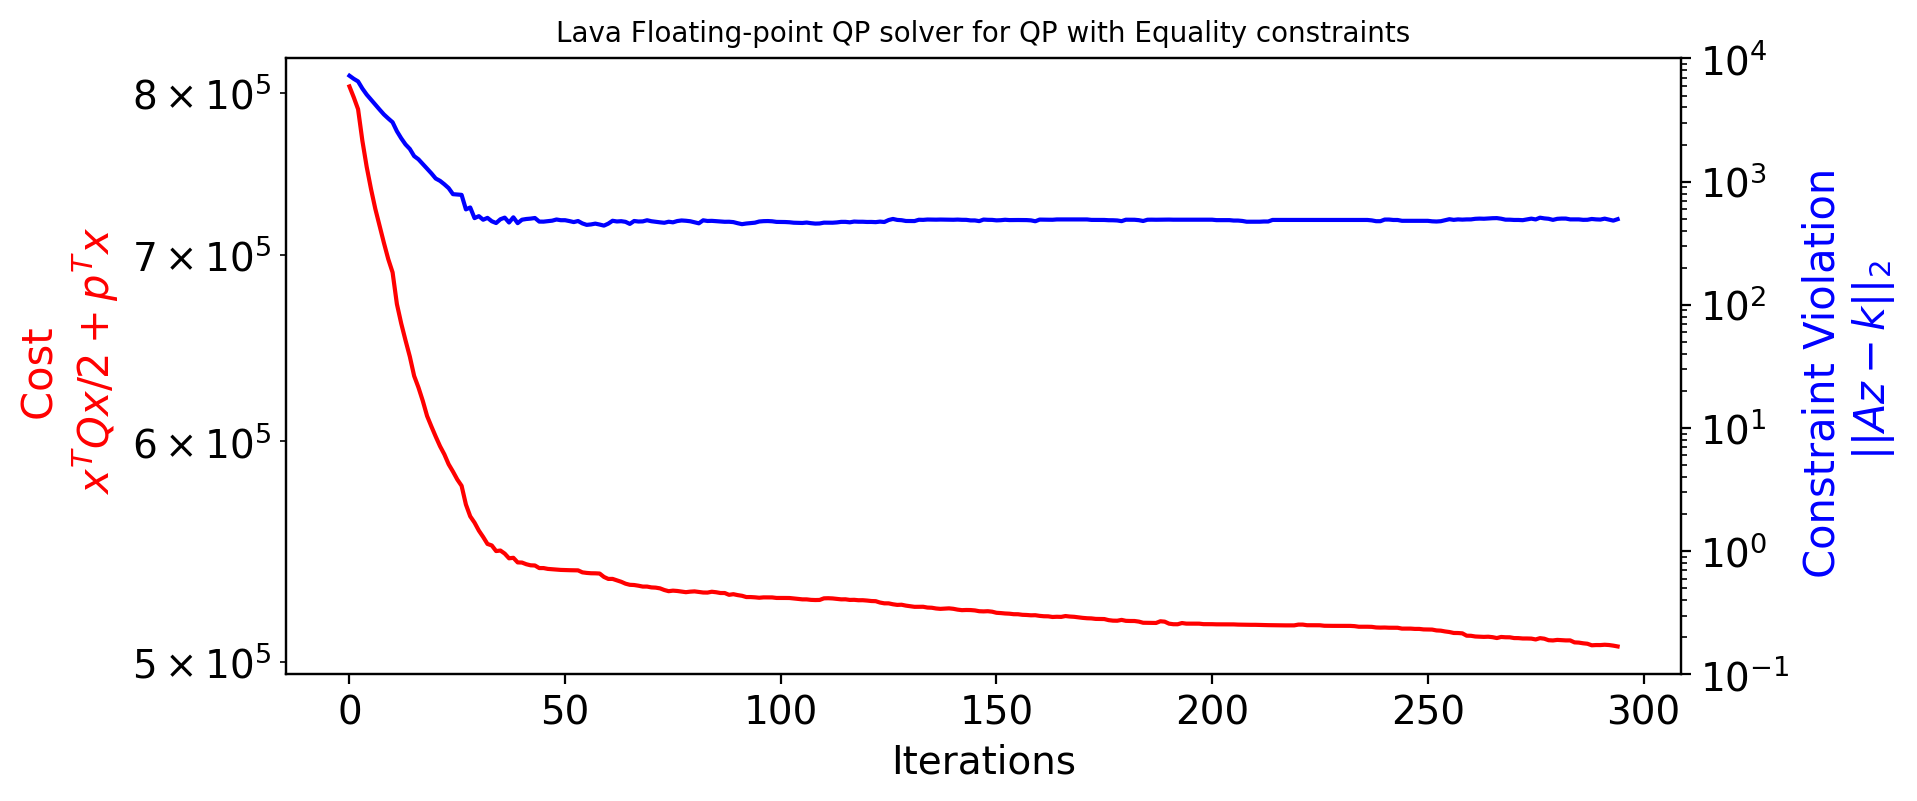

In [43]:
fig,ax = plt.subplots(figsize=(9, 4), dpi=200)
plt.rcParams.update({'font.size': 14})

plt.title("Lava Floating-point QP solver for QP with Equality constraints", fontsize=10)
ax.set_xlabel("Iterations")
ax.plot(cost[5:], color="red")
ax.set_ylabel("Cost \n $ x^T Q x / 2 + p^Tx $",fontsize=15, color="red")
ax.set_yscale('log')

ax2=ax.twinx()
ax2.plot(constraint_violation[5:],color="blue")
ax2.set_ylim(bottom=0.1, top=10000)
ax2.set_ylabel("Constraint Violation \n $ ||Az-k||_2 $",fontsize=15, color="blue")
ax2.set_yscale('log')
plt.show()

Note that the cost converges to a value that is in the range of the floating point version. From the plot of constraint violation it can be seen that the solver converges to a solution of limited accuracy because of the limitation imposed by the fixed-point representation. Future work on the Loihi 2 backend-based solver will aim to improve the solution accuracy.

## Benchmarking

In this section we make use of the profiling tool in Lava to meaure activity and run-time of the QP solver. We setup our Processes and enable the profiler tool before running the process models

In [32]:
import logging
from lava.utils.profiler import Profiler

ProjGrad = ProjectedGradientNeuronsPIPGeq(
            shape=(p_pre_fp_man.shape[0],),
            da_exp=correction_exp,
            grad_bias=p_pre_fp_man,
            grad_bias_exp=p_pre_fp_exp,
            alpha=alpha_man,
            alpha_exp=alpha_exp,
            lr_decay_type="indices",
            alpha_decay_params=(decay_index, decay_interval, decay_factor),
        )

# Neurons for Constraint Checking
ProInt = ProportionalIntegralNeuronsPIPGeq(
            shape=(k_pre_fp_man.shape[0],),
            da_exp=A_pre_fp_exp,
            thresholds=k_pre_fp_man,
            thresholds_exp=k_pre_fp_exp,
            beta=beta_man,
            beta_exp=beta_exp,
            lr_growth_type="indices",
            beta_growth_params=(growth_index, growth_factor),
        )
        
dense_Q = Dense(
    weights=Q_pre_fp_man, weight_exp=Q_exp_new, num_message_bits=24
)
dense_A = Dense(
    weights=A_pre_fp_man,
    num_message_bits=24,
)
dense_A_T = Dense(
    weights=A_pre_fp_man.T, weight_exp=A_exp_new, num_message_bits=24
)

# Connection topology
dense_Q.a_out.connect(ProjGrad.a_in_qc)
dense_A_T.a_out.connect(ProjGrad.a_in_qc)
ProjGrad.s_out_qc.connect(dense_A.s_in)
ProjGrad.s_out_qc.connect(dense_Q.s_in)
dense_A.a_out.connect(ProInt.a_in)
ProInt.s_out.connect(dense_A_T.s_in)

# Control this to increase/decrease solver iterations 
num_steps = 300*2



ProjGrad._log_config.level = logging.INFO
exception_proc_model_map = { 
    ProportionalIntegralNeuronsPIPGeq: NcL2ModelPI,
    ProjectedGradientNeuronsPIPGeq: NcL2ModelPG,
}

run_config = Loihi2HwCfg(exception_proc_model_map=exception_proc_model_map)

# Enabling activity and execution time loggers
profiler = Profiler.init(run_config)

profiler.execution_time_probe()
profiler.activity_probe()

ProjGrad.run(condition=RunSteps(num_steps=num_steps), run_cfg=run_config)
# x_pre = ProjGrad.qp_neuron_state.get()
ProjGrad.stop()

Violation core_id=0 reg_name='SynMem' allocation=33864 self.cost_db.registers[reg_name]=12000
Violation core_id=1 reg_name='SynMem' allocation=12144 self.cost_db.registers[reg_name]=12000
Final max_ratio=3, Violation core_id=0 reg_name='SynMem' allocation=33864 self.cost_db.registers[reg_name]=12000
Final max_ratio=2, Violation core_id=1 reg_name='SynMem' allocation=12144 self.cost_db.registers[reg_name]=12000
Final max_ratio=3, Violation core_id=0 reg_name='SynMem' allocation=29376 self.cost_db.registers[reg_name]=12000
Final max_ratio=2, Violation core_id=2 reg_name='SynMem' allocation=12144 self.cost_db.registers[reg_name]=12000
Final max_ratio=2, Violation core_id=4 reg_name='SynMem' allocation=12144 self.cost_db.registers[reg_name]=12000
Final max_ratio=2, Per core distribution:
----------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Cores |
|--------------------------------------------------------------|
|     408|

Below we access variables from the profiler to get measurements of execution time, spiking time, management time all for every timestep in the run. 
Note that the exeuction time can be varied by specifying an upper on the number of neurons allowed per core. This can be done by modifying the `LOIHI.db` file  

In [34]:
execution_time = np.mean(profiler.execution_time)
spiking_time = np.mean(profiler.spiking_time)
management_time = np.mean(profiler.management_time)
host_time = np.mean(profiler.host_time)
learning_time = np.mean(profiler.learning_time)
pre_lrn_mgmt_time = np.mean(profiler.pre_lrn_mgtm_time)
print(f'Mean execution time: {execution_time} s')
print(f'Mean spiking time: {spiking_time} s')
print(f'Mean management time: {management_time} s')
print(f'Mean host time: {host_time} s')
print(f'Total Execution time for the solver: {np.sum(profiler.execution_time)}')

Mean execution time: 3.962333333333334e-05 s
Mean spiking time: 3.955807215716884e-05 s
Mean management time: 6.526117616449483e-08 s
Mean host time: 0.0 s
Total Execution time for the solver: 0.023774000000000003


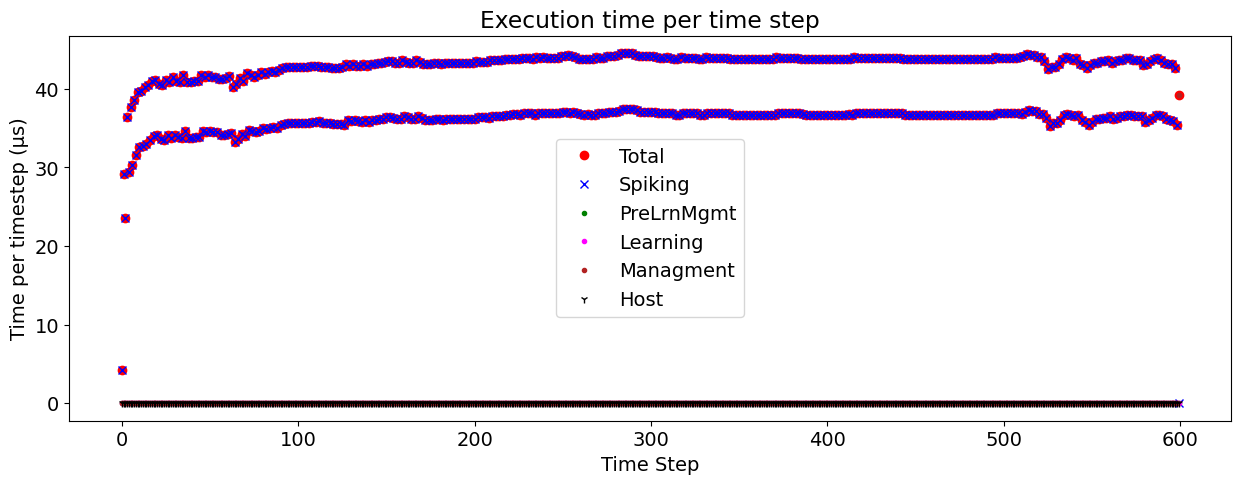

In [41]:
profiler.plot_execution_time()

Below we get the activity measurements over the total run of the solver. Note that these statistics can help indentify bottlenecks in the solver and help optimize and speed it up.  

In [35]:
num_neurons_per_core = (Q.shape[0] + A.shape[0])/len(profiler._activity_probe.core_idx)
print(f'{profiler._activity_probe.signature = }')
print(f'{profiler._activity_probe.chip_idx = }')
print(f'{profiler._activity_probe.core_idx = }')
print(f'{profiler._activity_probe.spikes_in = }')
print(f'{profiler._activity_probe.syn_map_reads = }')
print(f'{profiler._activity_probe.syn_map_writes = }')
print(f'{profiler._activity_probe.syn_mem_reads = }')
print(f'{profiler._activity_probe.syn_mem_writes = }')
print(f'{profiler._activity_probe.syn_ops = }')
print(f'{profiler._activity_probe.dendrite_updates = }')
print(f'{profiler._activity_probe.spike_axon_in = }')
print(f'{profiler._activity_probe.probe_axon_in = }')
print(f'{profiler._activity_probe.axon_out = }')
print(f'{num_neurons_per_core=}')

profiler._activity_probe.signature = '4e2f604e7c434f08f62be19760ca1511df07'
profiler._activity_probe.chip_idx = array([0, 0, 0, 0, 0, 0])
profiler._activity_probe.core_idx = array([0, 1, 2, 3, 4, 5])
profiler._activity_probe.spikes_in = array([173933, 173933, 173933, 173933, 135147, 135147])
profiler._activity_probe.syn_map_reads = array([173933, 173933, 173933, 173933, 135147, 135147])
profiler._activity_probe.syn_map_writes = array([0, 0, 0, 0, 0, 0])
profiler._activity_probe.syn_mem_reads = array([4174392, 4174392, 4174392, 2261129, 5405880,  810882])
profiler._activity_probe.syn_mem_writes = array([0, 0, 0, 0, 0, 0])
profiler._activity_probe.syn_ops = array([194264, 183028, 203276,  66226, 303795,  43321])
profiler._activity_probe.dendrite_updates = array([157500, 157500, 157500,  81900, 190500,  25500])
profiler._activity_probe.spike_axon_in = array([35702, 40119, 42372, 16954, 34544,  4242])
profiler._activity_probe.probe_axon_in = array([0, 0, 0, 0, 0, 0])
profiler._activity_pro

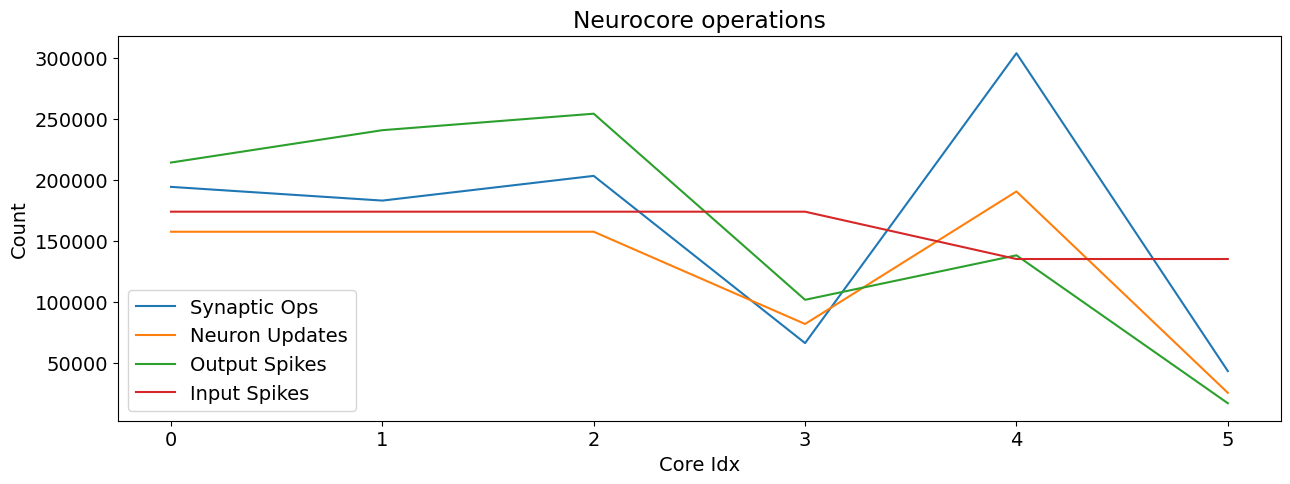

In [40]:
profiler.plot_activity()

### How to learn more?

Watch this [space](https://github.com/lava-nc/lava-optimization) to learn about upcoming developments to the QP solver and the optimization toolbox in Lava in general. 

If you want to find out more about the implementation of the QP solver, have a look at the [Lava documentation](https://lava-nc.org/ "Lava Documentation") or dive into the [source code](https://github.com/lava-nc/lava-optimization/tree/main/src/lava/lib/optimization/solvers/qp
"QP source code").
To receive regular updates on the latest developments and releases of the Lava Software Framework please subscribe to the [INRC newsletter](http://eepurl.com/hJCyhb "INRC Newsletter").